In [779]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy
import seaborn as sns

B S Q

# 0. Parameter settings

In [780]:
num_pop = 100
dimension = 10
size = 10 #(-100<= X <=100 by binary)

qtb_prob = 0.1 # 0.1, 0.2, 0.3 -> 절반
copy_prob = 0.9 # 0.7, 0.8, 0.9
surprise_prob = 0.05 # 0.01, 0.03, 0.05

function_selected = "Rosenbrock" #Sphere #Rastrigin #C01 #Rosenbrock

win_min = 3
max_iteration = 1500

# 관련 제약식! <<< dimension별로 범위가 다를 때 최대 자릿수를 조정해야함
power_list = []
for idx in range(0,dimension):
    power_list.append(7)
constraints = []
for idx in range(0, dimension):
       constraints.append([-100,100])
       
print(f'power_list: {power_list}, constraints: {constraints}')

power_list: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7], constraints: [[-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100], [-100, 100]]


# 1-1. Generate initial solutions

In [781]:
"""
generate_random_chromosome
: 하나의 chromosome 생성하기
"""
def generate_random_chromosome(size):
    chromosome = []
    
    # Chromosome
    current_size = 0
    while current_size < size:
        chromosome.append(random.randint(0,1))
        current_size = current_size + 1

    return chromosome

In [782]:
initial_chr = generate_random_chromosome(size)
initial_chr

[1, 1, 1, 0, 1, 1, 0, 0, 0, 0]

In [783]:
"""
chromosome_bin_to_decimal
: 하나의 chromosome을 십진법으로 변환
: 이진법 자릿수 이슈가 있기 때문에 추후 dimension 별로 최대 자릿수를 다르게 해야함
"""
def chromosome_bin_to_decimal(chromosome, power): 
    
    sum = 0
    # print(f'power: {power}')
    #
    for idx in range(0,len(chromosome)):
        # print((chromosome[0][idx]) * (2**power))
        sum = sum + (chromosome[idx]) * (2**power)
        power = power - 1
    
    return sum - 100

In [784]:
power = 6
chromosome_bin_to_decimal(initial_chr, power)

18.0

In [785]:
"""
generate_random_solution
: dimension 만큼 하나의 solution 만들기
: 이때 warm condition 확인
"""


def generate_random_solution(size, dimension):
    
    completed = -999
    
    # 생성
    while completed != 1:
        solution = []
        dim = 0
        while dim < dimension:
            #> 해를 만들고 warm 체크
            # 1. -100 ~ 100
            chromosome = generate_random_chromosome(size)
            value = chromosome_bin_to_decimal(chromosome, power_list[dim])
            if  (constraints[dim][0] <= (value)) & ((value) <= constraints[dim][1]):
                solution.append(chromosome)
                dim = dim + 1
            
                # 2. g(x) 준비
                sum_term = 0
                sum_term = sum_term + value**2 -5000 * np.cos(0.1*np.pi*value)-4000
        
        # 2. g(x) 확인
        if sum_term <= 0:
            completed = 1
            
    return solution
    

In [786]:
generate_random_solution(size, dimension)

[[1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
 [0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
 [1, 0, 1, 0, 0, 1, 1, 1, 1, 1],
 [1, 0, 1, 0, 0, 1, 1, 0, 0, 1],
 [0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 0, 0, 0],
 [0, 1, 1, 0, 0, 1, 1, 1, 0, 1],
 [1, 0, 1, 0, 0, 0, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 0, 1, 1, 0, 0],
 [0, 1, 1, 1, 0, 1, 1, 1, 1, 0]]

In [787]:
"""
generate_initial_solution
: 위에 함수 종합해서 num_pop 만큼 solution 만들기
: warm 확보되어 있음
"""
def generate_initial_solution(num_pop):
    pop = 1
    initial_solution = []
    while pop <= num_pop:
        initial_solution.append(generate_random_solution(size, dimension))
        pop = pop + 1
    return initial_solution

In [788]:
"""
calculate_solution_dec
: 이진법의 solution 형태를 동일한 구조로 십진법으로 계산해서 return
"""
def calculate_solution_dec(initial_solution):
    initial_solution_dec = []
    for idx in range(0, len(initial_solution)):
        
        temp = []
        for dim in range(0, len(initial_solution[idx])):
            temp.append(chromosome_bin_to_decimal(initial_solution[idx][dim], power_list[dim]))
            
        initial_solution_dec.append(temp)
    
    return initial_solution_dec

## Function (CEC2017?)

In [789]:
"""
주어진 function
: 추후 CEC2017로 교체
: solution 하나만!!! 십진법으로 계산하고 
"""
def Sphere_function(one_solution):
    #> 하나만 decimal로 계산하는 부분
    temp = []
    for dim in range(0, len(one_solution)):
        temp.append(chromosome_bin_to_decimal(one_solution[dim], power_list[dim]))
    
    # temp를 원하는 함수에 넣자
    sum_term = 0
    for element in temp:
        sum_term = sum_term + element**2
    
    return sum_term

def C01(one_solution):
    #> 하나만 decimal로 계산하는 부분
    temp = []
    for dim in range(0, len(one_solution)):
        temp.append(chromosome_bin_to_decimal(one_solution[dim], power_list[dim]))
    
    #>
    final_sum_term = 0
    for dim in range(0, dim+1):
        
        sum_term = 0
        for idx in range(0, dim+1):
            sum_term = sum_term + temp[idx]
        final_sum_term = final_sum_term + sum_term**2
    
    return final_sum_term
    
def C03_Rosenbrock(one_solution):
    #> 하나만 decimal로 계산하는 부분
    temp = []
    for dim in range(0, len(one_solution)):
        temp.append(chromosome_bin_to_decimal(one_solution[dim], power_list[dim]))
        
    #>
    final_sum_term = 0
    for dim in range(0, dimension-1):
        
        final_sum_term = final_sum_term + (100 * ((temp[dim])**2 -  (temp[dim+1]))**2 + (temp[dim] - 1)**2)
    
    return final_sum_term  
    
    

In [790]:
init_sol = generate_initial_solution(num_pop)
print(f'init_sol: {init_sol}')

# for dim in range(0, len(one_solution)):
#     temp.append(chromosome_bin_to_decimal(one_solution[dim], power_list[dim]))
print(f'dec: {calculate_solution_dec(init_sol)}')

init_sol: [[[1, 1, 0, 0, 0, 1, 0, 0, 1, 0], [0, 1, 1, 1, 0, 1, 1, 1, 0, 0], [1, 0, 1, 1, 1, 1, 1, 1, 1, 0], [1, 0, 1, 1, 1, 1, 0, 1, 0, 0], [1, 0, 0, 0, 0, 1, 1, 0, 1, 1], [1, 0, 0, 1, 1, 0, 1, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 0, 1, 1, 0, 1], [0, 0, 1, 0, 0, 0, 0, 1, 1, 0], [0, 0, 1, 1, 1, 1, 1, 0, 1, 0]], [[1, 0, 0, 0, 0, 1, 0, 0, 1, 1], [1, 0, 0, 1, 1, 0, 0, 1, 0, 1], [1, 0, 1, 0, 0, 0, 1, 1, 1, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 1, 1, 1, 0, 1, 1], [0, 1, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 1, 0, 0, 1, 0, 1, 1, 0], [0, 0, 0, 1, 1, 0, 1, 1, 0, 1], [0, 0, 1, 1, 0, 1, 0, 1, 0, 0], [0, 1, 1, 0, 1, 0, 1, 1, 0, 1]], [[0, 1, 0, 1, 1, 0, 1, 0, 1, 0], [1, 0, 0, 1, 0, 1, 0, 1, 0, 0], [1, 0, 1, 0, 1, 1, 1, 0, 0, 1], [1, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 0, 0, 0, 1, 1, 1], [1, 0, 1, 1, 1, 0, 1, 0, 0, 0], [1, 0, 1, 0, 1, 1, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 1], [0, 0, 1, 0, 0, 1, 1, 0, 0, 1], [0, 1, 1, 0, 1, 0, 0, 0, 0, 1]], [[0, 1, 0, 1, 1, 0, 0, 

In [791]:
# one_solution = [[0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1, 0, 0, 1]]
# # Sphere_function(one_solution)
# temp = []
# for dim in range(0, len(one_solution)):
#     temp.append(chromosome_bin_to_decimal(one_solution[dim], power_list[dim]))

# print(temp)

# final_sum_term = 0
# for dim in range(0, dim+1):
    
#     sum_term = 0
#     for idx in range(0, dim+1):
#         sum_term = sum_term + temp[idx]
#     final_sum_term = final_sum_term + sum_term**2
    
# print(final_sum_term)
        

# 1-2. Playbook

In [792]:
def initial_playbook():
    initial_playbook = generate_initial_solution(num_pop)
    
    return initial_playbook

# 1-3. Generate random pairs

In [793]:
"""
gen_random_pairs
: 0부터 num_pop만큼 생성하고 2개씩 묶기
"""

def gen_random_pairs():
    # random pair 생성
    pair_sample = random.sample(range(0,num_pop), num_pop)
     
    # 두개씩 묶기
    random_pair = []
    temp = []
    for idx in range(0,len(pair_sample)):
        
        temp.append(pair_sample[idx])
        if len(temp)==2:
            random_pair.append(temp)
            temp = []
        
    return random_pair

In [794]:
# gen_random_pairs()

# 2-1. Matchup

In [795]:
"""
?? Long pass / Scramble
?? Compare two squad's performance
"""

"\n?? Long pass / Scramble\n?? Compare two squad's performance\n"

In [796]:
"""
Long pass / Scramble
:
"""

'\nLong pass / Scramble\n:\n'

In [797]:
"""
compare_two_solutions
: 두개의 solution을 비교하기
"""

def compare_two_solutions(pair, solution1, solution2):
    win_index = -999
    lose_index = -999
    
    if C03_Rosenbrock(solution1) <= C03_Rosenbrock(solution2):
        win_index = pair[0]
        lose_index = pair[1]
        which_idx = 0
    else:
        win_index = pair[1]
        lose_index = pair[0]
        which_idx = 1

    # which_idx == 0 | 1
    return win_index, lose_index, which_idx


# 3-1. Break time

In [798]:
"""
copy oppents or playbook    
"""
def copy_opponents(win_chr, lose_chr):
    #> 위치 지정
    #: len(win_chr)+1 <- 이렇게 해야 밑에서 끝까지 할 수 있음
    #: 오름차순
    copy_loc = random.sample(range(0,(len(win_chr)+1)), 2)
    copy_loc.sort()
    
    #>
    for idx in range(copy_loc[0],copy_loc[1]):
        lose_chr[idx] = win_chr[idx]
        
    return lose_chr

In [799]:
"""
copy a playbook
"""

'\ncopy a playbook\n'

In [800]:
"""
surprise strategy
"""
def surprise(chromosome):
    surprise_loc = random.sample(range(0,len(chromosome)), 1)
    surprise_loc = surprise_loc[0]
    
    #>
    if chromosome[surprise_loc] == 1:
        chromosome[surprise_loc] = 0
    else:
        chromosome[surprise_loc] = 1
    
    
    return chromosome
    

In [801]:
"""
break_time
: 진 팀은 copy -> surprise
: 이긴 팀은 surprise 만
"""
def break_time(win_solution, lose_solution):

    # ==============================
    #> lose solution
    # ==============================
    #> 1. Copy oppenent's or playbook
    if random.random() <= copy_prob:
        
        for dim in range(0, len(lose_solution)):
            #> 복사
            win_chr = win_solution[dim]
            lose_chr = lose_solution[dim]
            
            #> win, lose chromosome만 보내서 lose만 return
            lose_solution[dim] = copy_opponents(win_chr, lose_chr)

    #> 2. Surprise
    if random.random() <= surprise_prob:
        
        for dim in range(0, len(lose_solution)):
            lose_solution[dim] = surprise(lose_solution[dim])

    # ==============================
    #> win solution
    # ==============================
    #> Surprise 만 적용
    if random.random() <= surprise_prob:
        
        for dim in range(0, len(win_solution)):
            win_solution[dim] = surprise(win_solution[dim])
    
    
    return win_solution, lose_solution

# 4-1. Post-processing

In [802]:
"""
select_best_pop
: 상위 num_pop 개의 솔루션 다시 담기

"""

def select_best_pop(mixed_solution):

    #>
    value_list = []
    for idx in range(0, len(mixed_solution)):
        value_list.append(C03_Rosenbrock(mixed_solution[idx]))

    value_list = np.array(value_list)
    s = value_list.argsort()

    #>
    return_solution = []
    for idx in range(0, num_pop):
        return_solution.append(mixed_solution[s[idx]])

    return return_solution

# 보조 함수

In [803]:
"""
solution 중에 최솟값을 return해주는 함수
"""
def min_value_return(solutions):
    min = 999999999999999999

    for idx in range(0, len(solutions)):
        
        val = C03_Rosenbrock(solutions[idx])
        if val < min:
            min = val
            
    # print(min)
    return min


In [804]:
"""
plot
: (1) iteration ~ 최소값
: (2) plot(n-dimensional?)
"""

# def plot_by_iteration()

'\nplot\n: (1) iteration ~ 최소값\n: (2) plot(n-dimensional?)\n'

# ★Iteration Chunk

In [805]:
min_sol_value_list = [] # 나중에 plot 그리려고 solution min값 모아 놓는 리스트

"""
# 1-1. 초기해 생성 initial_solution & 1
"""

initial_solution = generate_initial_solution(num_pop)
min_sol_value_list.append(min_value_return(initial_solution))

# initial_sol_dec = calculate_solution_dec(initial_solution)
# for i in range(0, len(initial_sol_dec)):
#     print(f'initial_solution x{i+1}: {initial_solution[i]} | {initial_sol_dec[i]}')


"""
# 1-2. 초기 playbook 생성
"""
playbook = initial_playbook()



current_solution = copy.deepcopy(initial_solution)


In [806]:
"""
# 1-3. 임의의 random pair 생성하기
"""
iteration = 1
while iteration <= max_iteration:
    print(f'iteration: {iteration}')
    
    random_pair = gen_random_pairs()
    # print(f'\nrandom_pair: {random_pair}')

    mixed_solution =  copy.deepcopy(current_solution)

    for idx in range(0, len(random_pair)): # all random pairs completed?
        """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
        *** 7판 4선 준비
        ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
        # 점수
        num_win_sol1 = 0
        num_win_sol2 = 0
            
        while ((num_win_sol1 != win_min) & (num_win_sol2 != win_min)):
            
            """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            # 2-1. Long pass/ Scramble 할지 정하기
            ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
            # Long pass
            
            
            """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            # 2-2. 선택된 두개의 solution(squad) 목적함수 비교하고 이긴(진) index 모으기
            ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
            #> win_idx, lose_idx
            temp_pair = random_pair[idx]
            win_idx, lose_idx, which_idx = compare_two_solutions(temp_pair, current_solution[temp_pair[0]], current_solution[temp_pair[1]])
            # print(f'win_idx: {win_idx}, lose_idx: {lose_idx} | {which_idx}')
    
            
            """ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
            # 3-1. Break time(이긴 solution / 진 solution)
            ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ"""
            #> current_solution에 갖다 붙이기!!
            win_solution, lose_solution = break_time(current_solution[win_idx], current_solution[lose_idx])
            
            current_solution[win_idx] = win_solution
            current_solution[lose_idx] = lose_solution
            
            
            if which_idx == 0:
                num_win_sol1 = num_win_sol1 + 1
            else:
                num_win_sol2 = num_win_sol2 + 1
                
        # print(f'{num_win_sol1} vs {num_win_sol2}')
                
    """
    # 4-1. 기존 100개 + New 100개
    """
    for idx in range(0, len(current_solution)):
        mixed_solution.append(current_solution[idx])

    # current_solution 갈아끼우기
    current_solution = select_best_pop(mixed_solution)
    min_sol_value_list.append(min_value_return(current_solution))
    
    # print(min_value_return(min_sol_value_list))
    
    iteration = iteration + 1

print(min_sol_value_list[-1])

iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
iteration: 72
i

# 그림

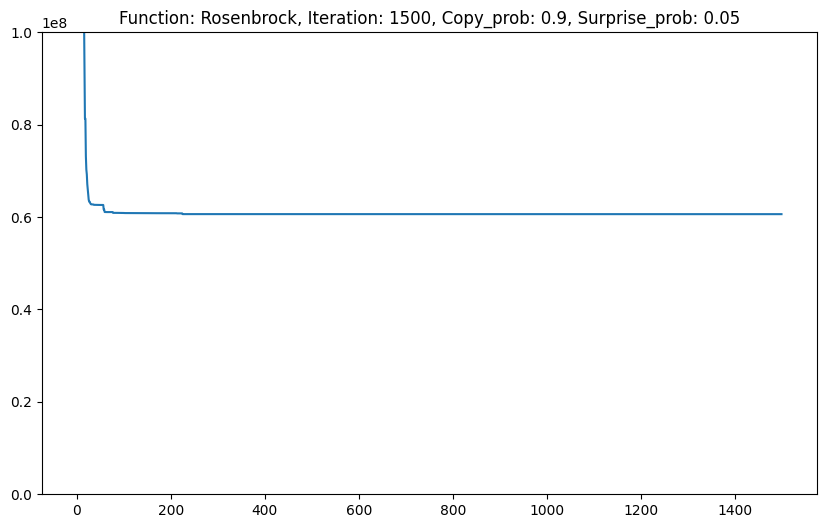

In [812]:
plt.figure(figsize=(10,6))
plt.plot(min_sol_value_list)
plt.ylim([0,100000000]) 
plt.title(f'Function: {function_selected}, Iteration: {max_iteration}, Copy_prob: {copy_prob}, Surprise_prob: {surprise_prob}')
plt.show()

# minimum value: {min(min_sol_value_list)}